In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

#### This notebook analyses the variants thrown into various Reference Genomes then called with Pilon from simulated reads

In [2]:
#import necessary packages
import vcf
import os
import pandas as pd
import numpy as np

###################################################################################

'''
#sort family proteins by ordering on H37Rv
Rv_number = pd.Series()
for Rv_ID in family_proteins:
    Rv_num = int(Rv_ID.split('v')[1][0:4])
    Rv_number[Rv_ID] = Rv_num
    
Rv_number.sort_values(ascending = True, inplace = True)
family_proteins = Rv_number.index
'''

###################################################################################

from itertools import compress
import ast
import itertools

import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from Bio import pairwise2
from shutil import copy

#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Collect DF of unique SNPs *dropped* into RefGenomes

In [3]:
##########################################################################################
##########################################################################################

'''
This piece of code imports the SNPs (Base Changes) that we want to simulate. The SNPs are taken from 
the Within-Host Base Call analysis. Unique Filtered SNPs from significant genes are stored in a DataFrame after 
determining which genes have a significant amount of variation.
'''

SNPs_from_all_patients_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/longitudinal_SNPs_to_simulate.pkl')

##########################################################################################
##########################################################################################

In [4]:
SNPs_from_all_patients_DF.head()

,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,SNP_type,AA_change
0,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,N,H445D
1,861378,T,G,Rv0768,467,Non-Essential,aldA,N,I156S
2,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,N,I443T
3,2075138,T,A,Rv1830,298,Non-Essential,NaN,N,S100T
4,2694727,A,G,Rv2397c,238,Essential,cysA1,N,F80L


In [5]:
np.shape(SNPs_from_all_patients_DF)

(151, 9)

#### Set of Genes with SNPs thrown in

In [6]:
novel_genes = list( set(SNPs_from_all_patients_DF.gene_id) )

#### Store the number of SNPs we're simulating for each gene (with at least 1 in-host SNP)

In [7]:
#dict to store the number of SNPs being 'thrown in' for each gene
num_simulated_SNPs_per_gene = {}

for gene_id in novel_genes:
    
    #all SNPs occuring on gene
    simlulated_SNPs_on_gene = SNPs_from_all_patients_DF[SNPs_from_all_patients_DF.gene_id == gene_id]
    
    #number of SNPs
    num_simulated_SNPs = np.shape(simlulated_SNPs_on_gene)[0]
    num_simulated_SNPs_per_gene[gene_id] = num_simulated_SNPs
    
num_simulated_SNPs_per_gene = pd.Series(num_simulated_SNPs_per_gene)

In [8]:
num_simulated_SNPs_per_gene.head()

Rv0005     1
Rv0006     4
Rv0041     1
Rv0095c    5
Rv0101     1
dtype: int64

### Collect all of the Alternate Allele Annotation Tables (CSV w/ actual variants thrown in per RefGenome) [SNP set $\beta$ ]

In [9]:
variant_annotation_CSV_dict = {}

RefGenome_Directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequence_info_and_calls_against_H37Rv/'
os.chdir(RefGenome_Directory)

#Good Reference Genomes (determined from from gene-length sliding window analyses)
RefGenome_folders = os.listdir(RefGenome_Directory)

for RefGenome_i in range(0 , len(RefGenome_folders)):

    RefGenome_folder = RefGenome_folders[RefGenome_i]
    
    #retrieve the CSV file with the SNPs we have introduced into the Reference Genome
    variant_annot_csv = pd.read_csv(RefGenome_Directory + '/' + RefGenome_folder + '/' + RefGenome_folder + '_altered_variants_record.csv').set_index('Unnamed: 0')
    
    #H37Rv Reference Positions start counting from 1 in this CSV file but start counting from 0 via Pilon VCF output, so subtract 1 from this column for downstream comparison and analysis
    variant_annot_csv['ref_position'] = variant_annot_csv.ref_position - 1
    
    #store csv of 'true' altered variants into dict
    variant_annotation_CSV_dict[RefGenome_folder] = variant_annot_csv

### Collect successful mappings (amongst the significant genes) for each Reference Genome

In [10]:
#for each RefGenome, store a list of Gene IDs for which we were able to map
H37Rv_RefGenome_successful_mappings = {}

for RefGenome_i in variant_annotation_CSV_dict.keys():

    Introduced_SNPs_for_RefGenome = variant_annotation_CSV_dict[RefGenome_i]
    
    #If a Gene had SNPs thrown into the Reference Genome, then the mapping from H37Rv to this Reference Genome was successful
    Genes_with_introduced_SNPs = list( set( Introduced_SNPs_for_RefGenome.gene_id ) ) 
    
    #store csv of 'true' altered variants into dict
    H37Rv_RefGenome_successful_mappings[RefGenome_i] = Genes_with_introduced_SNPs

### *Function* to call *original* SNPs between Reference Genome & H37Rv from MUMmer SNPs file and put into a dataframe

In [11]:
def SNPs_from_MUMmer_A(SNPs_file):
    
    '''
    This function takes as input, the isolate tag, then extracts SINGLE base calls from
    the SNPs file generated by MUMmer. The function returns a DataFrame for a single isolate
    that contains calls that support an alternate allele. These are exactly the 
    types of Base Calls that we are looking for. We want to retrieve the set of 'True' 
    Alternate Alleles of the Reference Genome against H37Rv and the set of Alternate Alleles 
    of the Modified Reference Genome against H37Rv. We can them compare the difference between these
    Base Calls to the set of SNPs that we introduced into the Modified Reference Genome to get an idea
    of how accurately we were able to recover the SNPs that we introduced.
    '''

    #Reference: H37Rv
    #Query: Complete Genome (RefGenome)

    #import SNPs file into DF
    #-------------------------------------------------------------
    #ref_position: position of the SNP in the reference sequence.
    #ref_base: character or gap at this position in the reference. 
    #alt_base: character or gap at this position in the query.
    #qry_position: position of the SNP in the query sequence.
    #BUFF: distance from this SNP to the nearest mismatch (end of alignment, indel, SNP, etc) in the same alignment
    #DIST: distance from this SNP to the nearest sequence end
    #LEN Ref: length of the reference sequence
    #LEN Qry: length of the query sequence
    #R: number of repeat alignments which cover this reference position
    #Q: number of repeat alignments which cover this query position
    #Ref_ID: reference FastA ID
    #Qry_ID: query FastA ID
    ##All positions are relative to the forward strand of the DNA input sequence
    #-------------------------------------------------------------
    Variant_Call_DF = pd.read_csv(SNPs_file , sep = '\t' , header = 2 , names = ['ref_position' , 'ref_base' , 'alt_base' , 'qry_position' , 'BUFF' , 'DIST' , 'LEN Ref' , 'LEN Qry' , 'R' , 'Q' , 'Ref_ID' , 'Qry_ID'])

    #drop unnecessary columns
    Variant_Call_DF.drop(labels = ['BUFF' , 'DIST' , 'LEN Ref' , 'LEN Qry' , 'R' , 'Q' , 'Ref_ID' , 'Qry_ID'] , axis = 1 , inplace = True)

    #re-order columns
    Variant_Call_DF = Variant_Call_DF.loc[: , ['ref_base' , 'alt_base' , 'ref_position' , 'qry_position']]

    #drop gaps in the Reference (H37Rv)
    Variant_Call_DF = Variant_Call_DF[Variant_Call_DF.ref_base != '.']

    #drop gaps in the Query (Complete (RefGenome) Genome)
    Variant_Call_DF = Variant_Call_DF[Variant_Call_DF.alt_base != '.']

    
    return Variant_Call_DF #DataFrame for base calls for a single isolate

### *Function* to call *introduced* SNPs between Reference Genome & H37Rv (impose INDEL, Mapping Quality and Base Quality Filters)

In [12]:
def SNPs_from_VCF_B(VCF_file):
    
    '''
    This function takes as input, the isolate tag, then extracts SINGLE base calls from
    the VCF file generated by Pilon. The function returns a DataFrame for a single isolate
    that contains ONLY PASS calls that support an alternate allele. These are exactly the 
    types of Base Calls that we are looking for. We want to retrieve the set of 'True' 
    Alternate Alleles of the Reference Genome against H37Rv and the set of Alternate Alleles 
    of the Modified Reference Genome against H37Rv. We can them compare the difference between these
    Base Calls to the set of SNPs that we introduced into the Modified Reference Genome to get an idea
    of how accurately we were able to recover the SNPs that we introduced.
    '''

    vcf_reader = vcf.Reader(open(VCF_file , 'r'))

    #create dictionaries to store information for each call
    ref_bases = {}
    qry_bases = {}
    ref_positions = {}
    quality_scores = {}
    SNP_type = {}
    INFO_for_call = {}
    
    #store the DEPTH of all base & variant calls (depth not stored for major structural variants)
    coverage_for_all_base_and_small_indel_calls = []
    
    #indexer for dataframe containing SNPs
    index = 0

    #iterate through each record from VCF file
    for record in vcf_reader:
            
        ######## Call supporting ALTERNATE ########
        #if there's 1 alternate allele, and Filter is PASS; PASS call supporting Alt allele
        if (len(record.ALT) == 1) and (record.ALT != [None]) and (record.FILTER == []):

            alt_allele = str( record.ALT[0] ) #alternate allele supported by reads
            ref_allele = record.REF #allele on H37Rv

            ### Filtering Criteria (for Reference Confirmation or SNP) [same filtering criteria used for real data]
            #---> Make sure that the length of all any alleles is 1 (No Variant or 1 Base) ; if variant, then variant is a SNP and not an INDEL
            if (len(ref_allele) == 1) and (len(alt_allele) == 1):
                
                ######## Retrieve Relevant information for filtering quality of Base Call ########
                
                # Mean Base Quality @ locus
                BQ = record.INFO['BQ']

                # Mean Mapping Quality @ locus
                MQ = record.INFO['MQ']

                # Number of Reads w/ Deletion 
                DC = record.INFO['DC']

                # Number of Reads w/ Insertion
                IC = record.INFO['IC']  
                
                # Depth of Valid Reads in Pileup
                VD = record.INFO['DP']

                ### Filtering Criteria
                #---> Mean Base Quality > 20
                #---> Mean Mapping Quality > 30
                #---> No Reads Supporting Insertions
                #---> No Reads Supporting Deletions
                #---> Number of High Quality Reads >= 25
                if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 25): #SNP passed filtering criteria!
                    
                    #After extensive filtering and categorization, store all of the pertinent information about the Base Call
                    ref_bases[index] = ref_allele
                    qry_bases[index] = alt_allele
                    ref_positions[index] = record.POS
                    quality_scores[index] = record.QUAL
                    SNP_type[index] = 'Alt_PASS'
                    INFO_for_call[index] = record.INFO

                    index += 1
                
    #convert dictionaries to series
    ref_bases = pd.Series(ref_bases)
    qry_bases = pd.Series(qry_bases)
    ref_positions = pd.Series(ref_positions)
    quality_scores = pd.Series(quality_scores)
    SNP_type = pd.Series(SNP_type)
    INFO_for_call = pd.Series(INFO_for_call)

    #create DataFrame to hold all base calls for a given sample
    Variant_Call_DF = pd.DataFrame()
    Variant_Call_DF['ref_base'] = ref_bases
    Variant_Call_DF['alt_base'] = qry_bases
    Variant_Call_DF['ref_position'] = ref_positions
    Variant_Call_DF['quality'] = quality_scores
    Variant_Call_DF['SNP_type'] = SNP_type
    Variant_Call_DF['INFO'] = INFO_for_call
    
    return Variant_Call_DF #DataFrame for base calls for a single isolate

### Collect all of the SNP calls from the SNPs files (that were output from MUMmer) from UNALTERED RefGenome simulations [SNP set A]

In [13]:
#natural variants against H37Rv
called_variants_SNP_set_A_dict = {}

# Iterate through all VCF files
for RefGenome_i in range(0 , len(RefGenome_folders)):   
    
    RefGenome_Directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequence_info_and_calls_against_H37Rv/'
    os.chdir(RefGenome_Directory)

    #Good Reference Genomes (determined from from gene-length sliding window analyses)
    RefGenome_folders = os.listdir(RefGenome_Directory)

    RefGenome_folder = RefGenome_folders[RefGenome_i]
    
    SNPs_file = RefGenome_Directory + RefGenome_folder + '/MUMmer_output_RefGenome/H37Rv_' + RefGenome_folder + '.snps'

    SNP_DF = SNPs_from_MUMmer_A(SNPs_file)
    
    #store a DF for each RefGenome
    called_variants_SNP_set_A_dict[RefGenome_folder] = SNP_DF

### Collect all of the SNP calls from the VCF files (that were output from Pilon) from ALTERED RefGenome simulations [SNP set B]

In [14]:
#natural variants + introduced variants against H37Rv
called_variants_SNP_set_B_dict = {}

# Iterate through all VCF files
for RefGenome_i in range(0 , len(RefGenome_folders)):   
    
    RefGenome_Directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequence_info_and_calls_against_H37Rv/'
    os.chdir(RefGenome_Directory)

    #Good Reference Genomes (determined from from gene-length sliding window analyses)
    RefGenome_folders = os.listdir(RefGenome_Directory)

    RefGenome_folder = RefGenome_folders[RefGenome_i]
    
    VCF_file = RefGenome_Directory + RefGenome_folder + '/' + 'SmPipe_output_ALT_RefGenome' + '/pilon/' + RefGenome_folder + '.vcf'

    SNP_DF = SNPs_from_VCF_B(VCF_file)
    
    #store a DF for each RefGenome
    called_variants_SNP_set_B_dict[RefGenome_folder] = SNP_DF

### Analyze Variant Calls detected *In-Host*

In [15]:
#retreive Annotation for the H37Rv Reference Genome, the Reference Genome all simulated reads were aligned against
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv_genome_summary.txt', '\t').set_index('name')

#create DF to sensitiviy (~recovery) & precision (~false calls)
sensitivity_DF = pd.DataFrame(index = novel_genes)
precision_DF = pd.DataFrame(index = novel_genes)

#create DF to store False Positives and True Positives
true_positives_DF = pd.DataFrame(index = novel_genes)
false_positives_DF = pd.DataFrame(index = novel_genes)

#Good Reference Genomes (determined from from gene-length sliding window analyses)
RefGenome_folders = os.listdir(RefGenome_Directory)

for RefGenome_i in range(0 , len(RefGenome_folders)):

    RefGenome_folder = RefGenome_folders[RefGenome_i]
    
    simulated_variants_DF = variant_annotation_CSV_dict[RefGenome_folder] #variants introduced into Reference Genome [Beta]
    called_variants_SNP_set_A_DF = called_variants_SNP_set_A_dict[RefGenome_folder] #variants called from mapping UNALTERED RefGenome [A] - original variants against H37Rv
    called_variants_SNP_set_B_DF = called_variants_SNP_set_B_dict[RefGenome_folder] #variants called from mapping ALTERED RefGenome [B] - original variants + introduced variants against H37Rv

    RefGenome_i_sensitivity_list = []
    RefGenome_i_precision_list = []
    
    RefGenome_i_true_postive_list = []
    RefGenome_i_false_positive_list = []
    
    #get list of RefGenome postions for all called variants from SNP set B ('NORMALIZE' by SNP set A, make sure we're only accounting for variant calls that we introduced)
    RefGenome_i_true_positive_list = list(set(called_variants_SNP_set_B_DF.ref_position) - set(called_variants_SNP_set_A_DF.ref_position)) # ['called' variants] == B - A
    
    #iterate through each gene for which variants were introduced
    for gene_id in novel_genes:

        #check to see if variants were introduced for this gene (for this Reference Genome)
        if (gene_id in set(list(simulated_variants_DF.gene_id))) and (gene_id in H37Rv_RefGenome_successful_mappings[RefGenome_folder]):
            
            #get start and end RefGenome positions for relvant CDS on H37Rv (since variants were called against H37Rv)
            gene_id_info = reference_genome_annotation.loc[gene_id , :]
            chrom_start = gene_id_info.chromStart
            chrom_end = gene_id_info.chromEnd

            #find the position of the first base relative to H37Rv in 5' -> 3'
            CDS_start = min(chrom_start , chrom_end)
            CDS_end = max(chrom_start , chrom_end)
            CDS_RefGenome_positions = range(CDS_start , CDS_end+1 , 1)

            #get a list of all RefGenome positions ON GENE where variants were introduced ('NORMALIZE' by SNP set A, make sure we're not saying we 'introduced' a SNP that was already there)
            introduced_variants_RefGenome_pos = list( set( simulated_variants_DF[simulated_variants_DF.gene_id == gene_id].ref_position) - set(called_variants_SNP_set_A_DF.ref_position) )  # ['introduced' variants] == Beta - A
            
            #list of Reference Positions where Alternate Alleles were introduced into Reference Genome and were called by pipeline
            true_positive_list_for_gene = set(RefGenome_i_true_positive_list).intersection(set(introduced_variants_RefGenome_pos)) 
            
            #list of Reference Positions where Alternate Alleles were NOT introduced and were called by pipeline
            true_positive_and_false_positive_list_for_gene = set(RefGenome_i_true_positive_list).intersection(set(CDS_RefGenome_positions)) #total calls
            false_positive_list_for_gene = true_positive_and_false_positive_list_for_gene - true_positive_list_for_gene
            
            #list of Reference Positions where Alternate Alleles were introduced into Reference Genome and were NOT called by pipeline
            false_negative_list_for_gene = set(introduced_variants_RefGenome_pos) - true_positive_list_for_gene
            
            #store number of True Positives & False Positives
            RefGenome_i_true_postive_list.append(float( len(true_positive_list_for_gene ) ))
            RefGenome_i_false_positive_list.append(float( len(false_positive_list_for_gene) ))

            #store sensitivity
            if len(true_positive_list_for_gene) + len(false_negative_list_for_gene) > 0: 
                
                sensitivity_gene_i = float( len(true_positive_list_for_gene) ) / float( len(true_positive_list_for_gene) + len(false_negative_list_for_gene) )
                RefGenome_i_sensitivity_list.append(sensitivity_gene_i)
                
            else:
                RefGenome_i_sensitivity_list.append(np.nan)
                
            #store precision
            if len(true_positive_list_for_gene) + len(false_positive_list_for_gene) > 0: 
                
                precision_gene_i = float( len(true_positive_list_for_gene) ) / float( len(true_positive_list_for_gene) + len(false_positive_list_for_gene) )
                RefGenome_i_precision_list.append(precision_gene_i)
                
            else:
                RefGenome_i_precision_list.append(np.nan)
        
        #did not introduce variants on gene for RefGenome (probably couldn't accurately find begin/end CDS on RefGenome for gene or len(introduced_variants_RefGenome_pos) = 0 (float division by zero))
        else:
            #store (lack of) recovery rate for gene
            RefGenome_i_sensitivity_list.append(np.nan)
            RefGenome_i_precision_list.append(np.nan)
            
            #store (lack of) false/true positives for gene 
            RefGenome_i_true_postive_list.append(np.nan)
            RefGenome_i_false_positive_list.append(np.nan)

    #store recovery rate & false positive rate values for RefGenome
    sensitivity_DF.loc[: , RefGenome_folder] = RefGenome_i_sensitivity_list
    precision_DF.loc[: , RefGenome_folder] = RefGenome_i_precision_list
    
    #store number of false positives & true postivies for RefGenome
    true_positives_DF.loc[: , RefGenome_folder] = RefGenome_i_true_postive_list
    false_positives_DF.loc[: , RefGenome_folder] = RefGenome_i_false_positive_list

#### Genes that had no successful Gene-CDS mappings amongst the 54 Reference Genomes

In [16]:
no_CDS_mapping_genes = set( list(precision_DF.mean(axis = 1)[precision_DF.mean(axis = 1).isnull()].index) )
print no_CDS_mapping_genes

set(['Rv0192A'])


#### Change ordering of genes to group by essential, non-essential, antibiotic_resistance, antigen & family-protein

In [18]:
# Get gene categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

novel_genes_ordered_by_H37Rv = []
for gene_id in gene_categories.gene_id:
    if gene_id in novel_genes:
        novel_genes_ordered_by_H37Rv.append(gene_id)
        
        
novel_genes_ordered_by_gene_category = []
for gene_category in ['Essential' , 'Non-Essential' , 'Antibiotic Resistance' , 'Antigen' , 'PE/PPE']:
    for gene_id in novel_genes_ordered_by_H37Rv:
        if gene_categories.loc[gene_id , :].Gene_Category == gene_category:
            novel_genes_ordered_by_gene_category.append(gene_id)
            
novel_genes = novel_genes_ordered_by_gene_category

#### Set threshold for number of False Calls allowed for each gene (by averaging across all simulations tested for each gene). Genes below this threshold determined to have a low rate of false calls & keep for further analysis. Genes that pass this threshold determined to have a high rate of false calls & discard for further analysis.

In [19]:
#dictionary to store number of successful mappings for each gene
not_nan_count_per_gene_dict = {}

#iterate through set of genes
for gene_id in novel_genes:
    
    gene_CDS_mapping_count = 0
    
    for RefGenome_i in H37Rv_RefGenome_successful_mappings.keys():
        
        if gene_id in H37Rv_RefGenome_successful_mappings[RefGenome_i]:
            
            gene_CDS_mapping_count += 1
    
    #store number of RefGenomes that H37Rv gene - RefGenome CDS mapping successful
    not_nan_count_per_gene_dict[gene_id] = gene_CDS_mapping_count
    
#convert dict to series
not_nan_count_per_gene_series = pd.Series(not_nan_count_per_gene_dict)

In [20]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '0.85'

### *Function* for boxplots

In [21]:
def customize_boxes(bp):
    
    linewidth_for_box = 1.15
    box_color = '0.2'
    
    #change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        
        #change outline color
        box.set(color = box_color , linewidth = linewidth_for_box)
        #change fill color
        #box.set(facecolor = 'white')
        
    #change color and linewidth of whiskers
    for whisker in bp['whiskers']:
        
        whisker.set(color = box_color , linewidth = linewidth_for_box)
        
    #change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color = box_color , linewidth = linewidth_for_box)
        
    #change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color = 'k' , linewidth = linewidth_for_box)
        
    #change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker = 'o' , markerfacecolor = box_color , markeredgewidth = 0.0 , markersize = 2.00 , markeredgecolor = 'k')

### Numbers of True Positives & False Positives

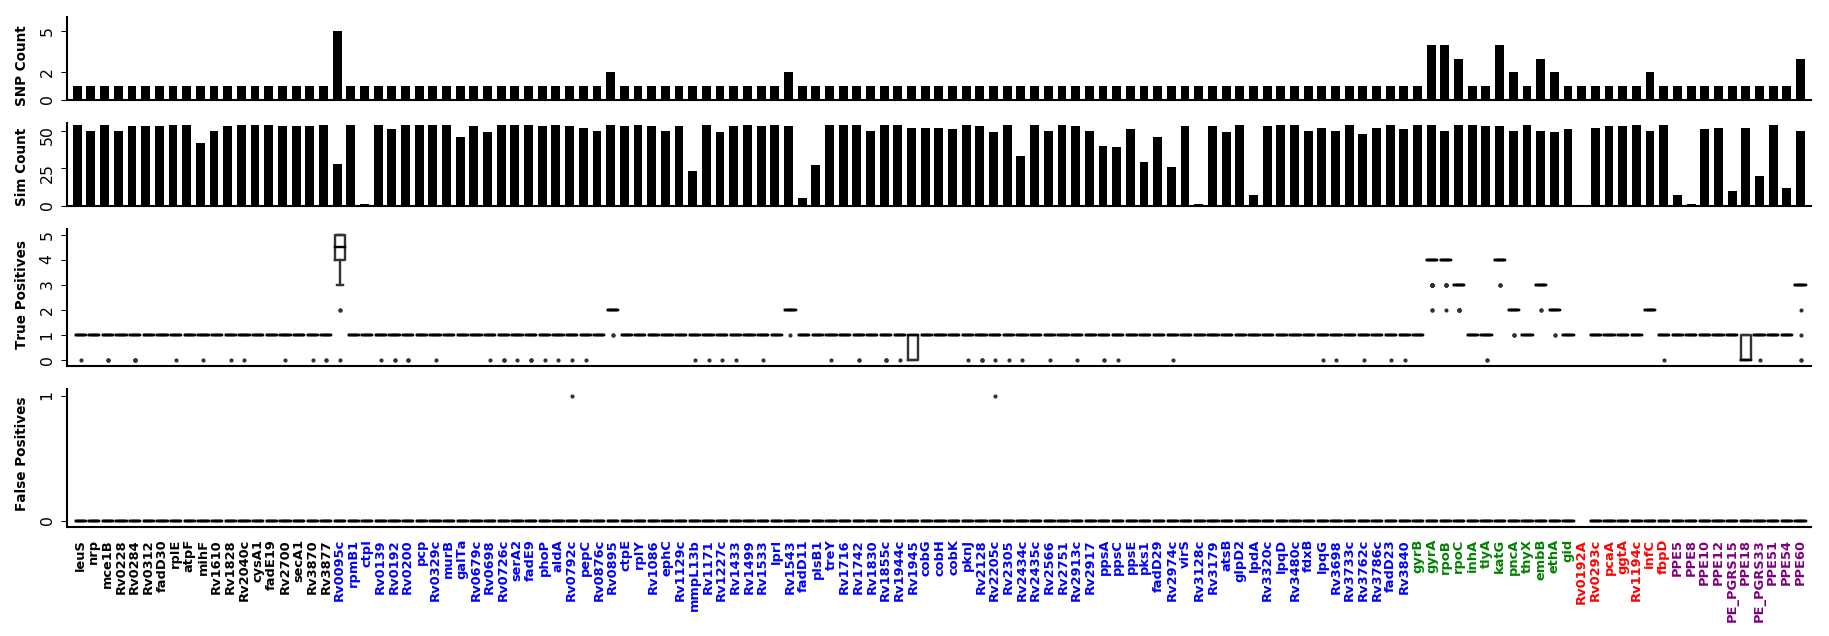

In [23]:
fig = plt.figure(figsize=(15, 4.5), dpi=150)
gs = gridspec.GridSpec(4, 1,
                       width_ratios=[1],
                       height_ratios=[1.5,1.5,2.5,2.5],
                       wspace=0.02,
                       hspace=0.21)

N = len(novel_genes)
ind = np.arange(N) # the x locations for the groups
width = 0.65 # the width of the bars: can also be len(x) sequence
box_width = 0.75 # width of the box plots

#colors to use for x-tick labels
gene_category_color_dict = {'Essential':'black' , 'Non-Essential':'blue' , 'Antibiotic Resistance':'green' , 'Antigen':'red' , 'PE/PPE':'purple' , 'Mobile Genetic Element':'orange'}

#barplot for number of SNPs introduced
ax = fig.add_subplot(gs[0], frameon=True)

barlist = ax.bar(ind, num_simulated_SNPs_per_gene[novel_genes].values, width , edgecolor = 'k' , color = 'k', linewidth = 0.0)

#ax.set_yscale("log", nonposy='clip')
ax.set_ylim(0 , np.max(num_simulated_SNPs_per_gene[novel_genes].values) + 1 )
ax.set_xlim([-0.75 , len(novel_genes) - 0.25])
ax.tick_params(labelbottom='off',bottom = 'off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#barplot for CDS mappings found
ax0 = fig.add_subplot(gs[1], frameon=True)

not_nan_count_per_gene_bars = ax0.bar(ind, not_nan_count_per_gene_series[novel_genes].values , width , edgecolor = 'k' , color = 'k' , linewidth = 0.0)

ax0.set_ylim(0 , max( not_nan_count_per_gene_series.values + 1 ))
ax0.set_xlim([-0.75 , len(novel_genes) - 0.25])
ax0.tick_params(labelbottom='off',bottom = 'off')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

             
#boxplot 1 (True Positives)
ax1 = fig.add_subplot(gs[2], frameon=True)

#prep data for barplots
TP_data_for_bp = []
for gene_i in novel_genes:
    gene_i_TP = true_positives_DF.T.loc[: , gene_i].dropna()
    TP_data_for_bp.append(gene_i_TP)

bp = ax1.boxplot(TP_data_for_bp , positions = ind , widths = box_width) 
customize_boxes(bp)

ax1.set_xlim([-1.0 , len(novel_genes) - 0.25])
ax1.tick_params(labelbottom='off',bottom = 'off')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#boxplot 2 (False Positives)
ax2 = fig.add_subplot(gs[3], frameon=True)

#prep data for barplots
FP_data_for_bp = []
for gene_i in novel_genes:   #recovery_rate_DF.T.columns:
    gene_i_FP = false_positives_DF.T.loc[: , gene_i].dropna()
    FP_data_for_bp.append(gene_i_FP)

bp = ax2.boxplot(FP_data_for_bp , positions = ind , widths = box_width)
customize_boxes(bp)

ax2.set_xlim([-1.0 , len(novel_genes) - 0.25])
ax2.tick_params(which = 'minor' , labelbottom='on', bottom = 'off')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#x-labels
gene_symbol_series = reference_genome_annotation.loc[novel_genes].symbol
for gene_id in gene_symbol_series.index:
    if isinstance(gene_symbol_series[gene_id] , str) == False:
        gene_symbol_series[gene_id] = gene_id

ax2.set_xticks(np.arange(0, len(novel_genes), 1.0), minor = True) #for labels
ax2.set_xticklabels(gene_symbol_series, rotation='vertical', fontsize = 6.25 , minor = True , fontweight = 'bold' , color = 'k')
#change color of xticks depending on gene category
colors_list = [gene_category_color_dict[ gene_categories.loc[gene_id , :].Gene_Category] for gene_id in gene_symbol_series.index]
[t.set_color(i) for (i,t) in zip(colors_list, ax2.xaxis.get_ticklabels(minor = True))]
ax2.tick_params(which = 'major' , labelbottom='off', bottom = 'off' , pad = 2)

#find the Maximum values for the False Positives & True Positives (across all genes & simulations) to set y-axis appropriately
max_FP = 0
max_TP = 0
for i in range(0 , len(FP_data_for_bp)):
    
    if len(FP_data_for_bp[i]) > 0:
        if max(FP_data_for_bp[i]) > max_FP:
            max_FP = max(FP_data_for_bp[i])
            
    if len(TP_data_for_bp[i]) > 0:
        if max(TP_data_for_bp[i]) > max_TP:
            max_TP = max(TP_data_for_bp[i])

#set y-ticks
y = [0 , int(max(num_simulated_SNPs_per_gene[novel_genes].values)/2) , max(num_simulated_SNPs_per_gene[novel_genes].values)]
ax.set_yticks(y)
ax.set_yticklabels(y , minor = False, fontsize = 7.5 , rotation = 90)
ax.tick_params(axis='y', which='major', pad=3 , length = 3 , width = 0.5 , colors = 'black')
ax.set_yticks([] , minor = True)

y0 = [0 , 25 , 50]
ax0.set_yticks(y0)
ax0.set_yticklabels(y0 , minor = False, fontsize = 7.5 , rotation = 90)
ax0.tick_params(axis='y', which='major', pad=3 , length = 3 , width = 0.5 , colors = 'black')

y1 = range(0 , int(max_TP + 1))
ax1.set_yticks(y1)
ax1.set_yticklabels(y1 , minor = False, fontsize = 7.5 , rotation = 90)
ax1.tick_params(axis='y', which='major', pad=3 , length = 3 , width = 0.5 , colors = 'black')

y2 = range(0 , int(max_FP + 1))
ax2.set_yticks(y2)
ax2.set_yticklabels(y2 , minor = False, fontsize = 7.5 , rotation = 90)
ax2.tick_params(axis='y', which='major', pad=3 , length = 3 , width = 0.5 , colors = 'black')

#add y-labels
fig.text(0.105, 0.235, 'False Positives' ,  ha='center', va='center', rotation=90, fontsize = 6.5 , color = 'black', fontweight = 'bold')
fig.text(0.105, 0.47, 'True Positives' ,  ha='center', va='center', rotation=90, fontsize = 6.5 , color = 'black', fontweight = 'bold')
fig.text(0.105, 0.66, 'Sim Count' ,  ha='center', va='center', rotation=90, fontsize = 6.5 , color = 'black', fontweight = 'bold')
fig.text(0.105, 0.81, 'SNP Count' ,  ha='center', va='center', rotation=90, fontsize = 6.5 , color = 'black', fontweight = 'bold')


file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/SNP_recall_simulations/True_and_False_Positives_from_simulations.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()